# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.datasets import load_boston

from IPython.core.display import HTML, Markdown

## Look at a baseline boston housing data model

- Import the Boston housing dataset 
- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [2]:
# Your code here
random_state = 1
boston = load_boston()
boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [3]:
y = pd.DataFrame(boston['target'], columns=['target'])
print(y.info(), "\n\n")

all_feats = boston['feature_names']

X = pd.DataFrame(boston['data'], columns=all_feats)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  506 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB
None


In [4]:
X_scaled = pd.DataFrame(scale(X), columns=all_feats)

In [5]:
def build_fit_lrm(X, y, linreg, nofit=False, verbose=True):
    lrm = linreg if nofit else linreg.fit(X, y)
    y_hat = lrm.predict(X)

    # scores
    r2 = lrm.score(X, y)
    mse = mean_squared_error(y, y_hat)

    # Print R2 and MSE for training and test sets
    if verbose:
        display(Markdown("$R^2=" + str(r2) + ", MSE=" + str(mse) + "$"))

    return (lrm, r2, mse)


def build_fit_rm_test_train(X_train, y_train, X_test, y_test, linreg):
    lrm, r2_train, mse_train = build_fit_lrm(X_train, y_train, linreg, verbose=False)
    lrm, r2_test, mse_test = build_fit_lrm(X_test, y_test, linreg, nofit=True, verbose=False)

    # Print R2 and MSE for training and test sets
    display(Markdown("$R^2_{train}=" + str(r2_train) + ", R^2_{test}=" + str(r2_test) + "$"))
    display(Markdown("$MSE_{train}=" + str(mse_train) + ", MSE_{test}=" + str(mse_test) + "$"))

    return (lrm, r2_train, r2_test, mse_train, mse_test)

In [6]:
def eval_lrm(lrm, X, y, cvfolds, label="train", scoring_method='r2', verbose=True):
    cvscore = np.mean(cross_val_score(lrm, X, y, scoring=scoring_method, cv=cvfolds))
    if verbose:
        display(Markdown("$crossval\\_score" + ("_{" + label + "}" if label is not None else "") + "=" + str(cvscore) + "$"))

    return cvscore

In [7]:
lrm = LinearRegression()
cvfolds = KFold(n_splits=5, shuffle=True, random_state=random_state)
cvscore_baseline = eval_lrm(lrm, X_scaled, y, cvfolds, label=None)

$crossval\_score=0.7176778617934925$

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [8]:
# Your code here
from itertools import combinations
two_elt_feat_combos = list(combinations(all_feats, 2))
print(f"There are {len(two_elt_feat_combos)} 2-element feature combinations (possible interactions) from {all_feats}\n")

optimal_interactions = []
X_scaled_interaction = X_scaled.copy()
for two_elt_feat_combo in two_elt_feat_combos:
    f1 = two_elt_feat_combo[0]
    f2 = two_elt_feat_combo[1]
    X_scaled_interaction[f"{f1}_{f2}"] = X_scaled_interaction[f1] * X_scaled_interaction[f2] # replace
    cvscore = eval_lrm(lrm, X_scaled_interaction, y, cvfolds, label=None, verbose=False)
    if cvscore > cvscore_baseline:
        print(f"New better-baseline-interaction {two_elt_feat_combo}: score={cvscore}")
        optimal_interactions.append((two_elt_feat_combo, cvscore))

top_7_interactions = sorted(optimal_interactions, key=lambda interaction: interaction[1], reverse=True)[:7]
print(f"\nThe 7 best interactions are:\n{top_7_interactions}")

There are 78 2-element feature combinations (possible interactions) from ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']

New better-baseline-interaction ('CRIM', 'DIS'): score=0.7218057209375124
New better-baseline-interaction ('CRIM', 'RAD'): score=0.7246522981589087
New better-baseline-interaction ('CRIM', 'TAX'): score=0.7244564132962472
New better-baseline-interaction ('CRIM', 'PTRATIO'): score=0.7213218912375484
New better-baseline-interaction ('ZN', 'PTRATIO'): score=0.7193043942851005
New better-baseline-interaction ('ZN', 'B'): score=0.7190288514919799
New better-baseline-interaction ('ZN', 'LSTAT'): score=0.7188265673504628
New better-baseline-interaction ('INDUS', 'NOX'): score=0.7181972246019792
New better-baseline-interaction ('INDUS', 'RM'): score=0.7422829311861282
New better-baseline-interaction ('INDUS', 'AGE'): score=0.7431605589966865
New better-baseline-interaction ('INDUS', 'DIS'): score=0.735743380341471
New better-baseline-i

Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2" with var1 and var2 the two variables in the interaction.

In [9]:
# Your code here
X_scaled_interaction = X_scaled.copy()
for optimal_interaction in top_7_interactions:
    f1 = optimal_interaction[0][0]
    f2 = optimal_interaction[0][1]
    X_scaled_interaction[f"{f1}_{f2}"] = X[f1] * X[f2] # replace

cols_with_interactions = list(X_scaled_interaction.columns)
X_scaled_interaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           506 non-null    float64
 1   ZN             506 non-null    float64
 2   INDUS          506 non-null    float64
 3   CHAS           506 non-null    float64
 4   NOX            506 non-null    float64
 5   RM             506 non-null    float64
 6   AGE            506 non-null    float64
 7   DIS            506 non-null    float64
 8   RAD            506 non-null    float64
 9   TAX            506 non-null    float64
 10  PTRATIO        506 non-null    float64
 11  B              506 non-null    float64
 12  LSTAT          506 non-null    float64
 13  TAX_PTRATIO    506 non-null    float64
 14  TAX_LSTAT      506 non-null    float64
 15  TAX_B          506 non-null    float64
 16  PTRATIO_B      506 non-null    float64
 17  PTRATIO_LSTAT  506 non-null    float64
 18  RAD_LSTAT 

## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('DIS', 3, 0.732)` 

In [10]:
# Your code here
from sklearn.preprocessing import PolynomialFeatures

polynomials = []
for deg in range(2,5):
    for feat in X_scaled.columns:   # make sure no interactions are included (don't base on X_scaled_interaction columns)
        X_scaled_copy = X_scaled.copy()
        p = PolynomialFeatures(deg, include_bias=False) # include_base=False since "If True (default), then include a bias column, the feature in which all polynomial powers are zero (i.e. a column of ones - acts as an intercept term in a linear model)"
        X_poly_transformed = p.fit_transform(X[[feat]])

        # the second part of "we only want to include 'pure' polynomials": include all features from X_scaled (without feat) plus the feats from X_poly
        X_scaled_with_poly = pd.concat([X_scaled_copy.drop(feat, axis=1), pd.DataFrame(X_poly_transformed)], axis=1)

        cvscore = eval_lrm(lrm, X_scaled_with_poly, y, cvfolds, label=None, verbose=False)
        if cvscore > cvscore_baseline:
            polynomial = (feat, deg, cvscore)
            print(f"New better-than-baseline polynomial: {polynomial}")
            polynomials.append(polynomial)

polynomials = sorted(polynomials, key=lambda poly: poly[2], reverse=True)
print(f"\nThe 7 best polynomials are:\n{polynomials[:7]}")

New better-than-baseline polynomial: ('ZN', 2, 0.7204599327729518)
New better-than-baseline polynomial: ('INDUS', 2, 0.7230402221641345)
New better-than-baseline polynomial: ('NOX', 2, 0.7181189684400265)
New better-than-baseline polynomial: ('RM', 2, 0.7822643336772179)
New better-than-baseline polynomial: ('AGE', 2, 0.7209589264454014)
New better-than-baseline polynomial: ('DIS', 2, 0.7319844470509823)
New better-than-baseline polynomial: ('TAX', 2, 0.7188025395029423)
New better-than-baseline polynomial: ('PTRATIO', 2, 0.7209138735779005)
New better-than-baseline polynomial: ('B', 2, 0.7196648980449971)
New better-than-baseline polynomial: ('LSTAT', 2, 0.7718449087479478)
New better-than-baseline polynomial: ('ZN', 3, 0.7232094006605265)
New better-than-baseline polynomial: ('INDUS', 3, 0.723298620579324)
New better-than-baseline polynomial: ('NOX', 3, 0.7183171605431375)
New better-than-baseline polynomial: ('RM', 3, 0.7807282811018531)
New better-than-baseline polynomial: ('AGE', 

For each variable, print out the maximum R2 possible when including Polynomials.

In [11]:
# Your code here
df_poly = pd.DataFrame(polynomials, columns=['base_feat', 'degree', 'r2'])
df_poly.head()

,base_feat,degree,r2
0,RM,4,0.800391
1,RM,2,0.782264
2,LSTAT,4,0.781953
3,RM,3,0.780728
4,LSTAT,3,0.774020


In [12]:
display(Markdown("### Max $R^2$"))
df_poly_max_r2 = pd.DataFrame(df_poly.groupby('base_feat')['r2'].max())
df_poly_max_r2

### Max $R^2$

,r2
base_feat,
AGE,0.722235
B,0.719665
DIS,0.736636
INDUS,0.723299
LSTAT,0.781953
NOX,0.720511
PTRATIO,0.720914
RAD,0.719531
RM,0.800391


Which two variables seem to benefit most from adding polynomial terms?

In [13]:
ascending_r2_poly = df_poly_max_r2.reset_index().sort_values('r2', ascending=False)
ascending_r2_poly.columns = ['feat', 'max_r2']
display(HTML(ascending_r2_poly.to_html()))

best_two_poly = ascending_r2_poly.feat[:2]
display(HTML(f"<p><br>The top two features which benefit the most by adding poly terms are:\n{list(best_two_poly)}"))

,feat,max_r2
8,RM,0.800391
4,LSTAT,0.781953
2,DIS,0.736636
9,TAX,0.724010
3,INDUS,0.723299
10,ZN,0.723209
0,AGE,0.722235
6,PTRATIO,0.720914
5,NOX,0.720511
1,B,0.719665


Add Polynomials for the two features that seem to benefit the most, as in have the best R squared compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [14]:
# Your code here
# from above, we see that RM and LSTAT produce the best results in that order and their corresponding degrees are 4 (both)
for best_poly_feat in best_two_poly:
    p = PolynomialFeatures(4, include_bias=False)
    X_poly_transformed = p.fit_transform(X[[best_poly_feat]])
    cols = [best_poly_feat, f"{best_poly_feat}2", f"{best_poly_feat}3", f"{best_poly_feat}4"] # corresponding powers
    X_scaled_interaction = pd.concat([X_scaled_interaction.drop(best_poly_feat, axis=1), pd.DataFrame(X_poly_transformed, columns=cols)], axis=1)

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [15]:
# Your code here
cols_with_interactions_and_polys = list(X_scaled_interaction.columns)
X_scaled_interaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           506 non-null    float64
 1   ZN             506 non-null    float64
 2   INDUS          506 non-null    float64
 3   CHAS           506 non-null    float64
 4   NOX            506 non-null    float64
 5   AGE            506 non-null    float64
 6   DIS            506 non-null    float64
 7   RAD            506 non-null    float64
 8   TAX            506 non-null    float64
 9   PTRATIO        506 non-null    float64
 10  B              506 non-null    float64
 11  TAX_PTRATIO    506 non-null    float64
 12  TAX_LSTAT      506 non-null    float64
 13  TAX_B          506 non-null    float64
 14  PTRATIO_B      506 non-null    float64
 15  PTRATIO_LSTAT  506 non-null    float64
 16  RAD_LSTAT      506 non-null    float64
 17  B_LSTAT        506 non-null    float64
 18  RM        

## Full model R-squared

Check out the R-squared of the full model.

In [16]:
# Your code here
cvscore_full_model = eval_lrm(lrm, X_scaled_interaction, y, cvfolds, label="fullmodel")

$crossval\_score_{fullmodel}=0.8250458218746205$

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

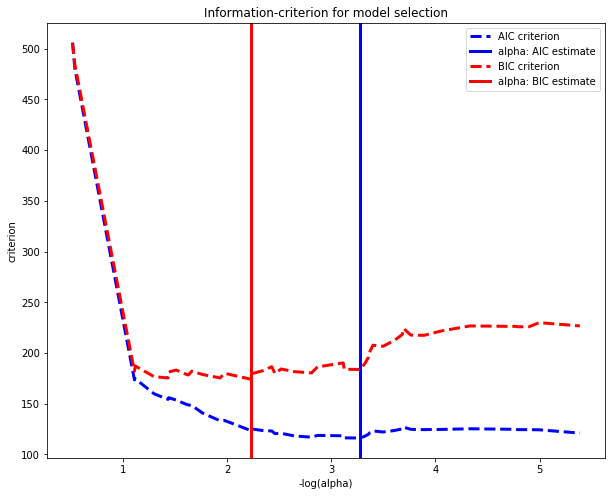

In [18]:
# Your code here 

# credit to https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html as a lot of code below is borrowed from there

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_scaled_interaction, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_scaled_interaction, y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_ #+ EPSILON
    alphas_ = model.alphas_ #+ EPSILON
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3, label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure(figsize=(10,8))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')
plt.show()

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare R-squared and MSE using train-test split. Compare with the baseline model.

In [19]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [20]:
# Split X_scaled and y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=random_state)

# Code for baseline model
linreg_all, r2_train, r2_test, mse_train, mse_test = build_fit_rm_test_train(X_train, y_train, X_test, y_test, LinearRegression())

$R^2_{train}=0.7168057552393374, R^2_{test}=0.7789410172622857$

$MSE_{train}=22.477983821877896, MSE_{test}=21.897765396049497$

In [21]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_scaled_interaction, y, test_size=0.25, random_state=random_state)

# Code for lasso with alpha from AIC
lasso, r2_train, r2_test, mse_train, mse_test = build_fit_rm_test_train(X_train, y_train, X_test, y_test, Lasso(alpha=alpha_aic_))

$R^2_{train}=0.8122056893225468, R^2_{test}=0.9029060046362548$

$MSE_{train}=14.905802484849302, MSE_{test}=9.617982972277902$

In [22]:
# Code for lasso with alpha from BIC
lasso, r2_train, r2_test, mse_train, mse_test = build_fit_rm_test_train(X_train, y_train, X_test, y_test, Lasso(alpha=alpha_bic_))

$R^2_{train}=0.811452134817872, R^2_{test}=0.9008257432217867$

$MSE_{train}=14.965614385261675, MSE_{test}=9.824050492594516$

## Level up (Optional)

### Create a Lasso path

From this section, you know that when using lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Boston housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 